# Prediction with Posters

In [39]:
import pandas as pd
import numpy as np
from scipy import io
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter("ignore")

from keras.models import Model
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator 
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense 
from keras import backend as K 
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import Callback
from sklearn.model_selection import KFold, cross_val_score

def mae(y, y_hat):
    return np.mean(np.abs(y - y_hat))

def rmse(y, y_hat):
    return np.sqrt(np.mean((y - y_hat)**2))

posters = io.loadmat("../data/posters.mat")
movies = pd.read_csv("../data/movies_with_words.csv")

We start by checking that we have only unique movie IDs and then collecting the poster 3-tensors into an array `X` and the corresponding labels into `y`.

In [43]:
all_ids = [str(i) for i in movies["id"] if str(i) in posters and posters[str(i)].shape == (92, 140, 3)]

In [44]:
len(np.unique(all_ids)) - len(all_ids)

-746

In [45]:
ids = np.unique(all_ids)

In [46]:
X = np.stack([posters[i] for i in ids])

movies_by_id = movies.set_index("id")
y = np.stack([int(movies_by_id.loc[int(i),"rating"].iloc[0]) if type(movies_by_id.loc[int(i),"rating"]) \
              == pd.Series else int(movies_by_id.loc[int(i),"rating"]) for i in ids])

In [47]:
X.shape

(1697, 92, 140, 3)

In [48]:
y.shape

(1697,)

Now we one-hot encode `y` so that we can train neural networks on it.

In [50]:
encoder = LabelEncoder()
encoder.fit(np.arange(11))
encoded_y = encoder.transform(y)
dummy_y = np_utils.to_categorical(encoded_y)

The data is now split into training and testing sets and labels and flattened versions are created.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y)

In [53]:
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

In [54]:
flattened_shape = (X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3])
flattened_X_train = X_train.reshape(flattened_shape)
flattened_X_test = X_test.reshape((X_test.shape[0], flattened_shape[1]))

The cells below define some useful constants and methods to build models in keras and run cross-validation on them, as well as some utilities for visualizing features in the networks.

In [56]:
epochs = 100
batch_size = 100
img_size = (92, 140)
input_shape = img_size + (3,)

In [131]:
def run_keras_cv(model_fn, X=X_train, y=y_train, epochs=10, batch_size=16, error_fn=mae, seed=42, verbose=0):
    np.random.seed(seed)
    estimator = KerasClassifier(build_fn=model_fn, epochs=epochs, batch_size=batch_size, verbose=verbose)
    kfold = KFold(n_splits=5, shuffle=True)
    scorer = lambda e, X, y: error_fn(np.argmax(y, axis=1), e.predict(X))
    results = cross_val_score(estimator, X, y, cv=kfold, n_jobs=-1, scoring=scorer)
    return estimator, results

In [63]:
def get_errors(estimator, X=X_train, y=y_train, Xt=None, yt=None, test=False, seed=42):
    np.random.seed(seed)
    estimator.fit(X, y)
    if test:
        pred = estimator.predict(Xt)
        return mae(np.argmax(yt, axis=1), pred), rmse(np.argmax(yt, axis=1), pred)
    else:
        pred = estimator.predict(X)
        return mae(np.argmax(y, axis=1), pred), rmse(np.argmax(y, axis=1), pred)

In [126]:
def visualize_layer(est, layer_idx, shape, figsize):
    img = np.expand_dims(X_train[1], axis=0)
    model = est.model
    model = Model(inputs=model.inputs, outputs=model.layers[layer_idx].output)
    feature_map = model.predict(img)

    plt.figure(figsize=figsize)
    i = 0
    for j in range(shape[0]):
        for k in range(shape[1]):
            if i >= feature_map.shape[3]:
                break
            plt.subplot(shape[0], shape[1], i+1)
            plt.imshow(feature_map[0, :, :, i], cmap='gray')
            i += 1

The image below is the poster that will be used when visualizing features.

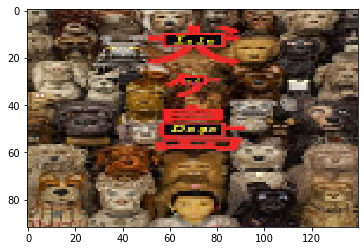

In [124]:
plt.imshow(X_train[1], cmap='gray')
plt.savefig('../figures/isle_of_dogs_poster.png')

In this section, we train various convolutional and non-convolutional neural networks.

In [59]:
def first_nn_model():
    model = Sequential() 
    model.add(Conv2D(32, (2, 2), input_shape=input_shape)) 
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2))) 

    model.add(Conv2D(32, (2, 2))) 
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2))) 

    model.add(Conv2D(64, (2, 2))) 
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2))) 

    model.add(Flatten()) 
    model.add(Dense(64)) 
    model.add(Activation('relu')) 
    model.add(Dropout(0.5)) 
    model.add(Dense(dummy_y.shape[1])) 
    model.add(Activation('sigmoid'))
    
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["mae", "mse"])

    return model

In [61]:
%%time
first_estimator, first_results = run_keras_cv(first_nn_model)

CPU times: user 130 ms, sys: 296 ms, total: 426 ms
Wall time: 7min 1s


In [62]:
first_results.mean(), first_results.std()

(3.7359178632082752, 1.7413004034397939)

In [64]:
get_errors(first_estimator)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


(2.5849056603773586, 3.036983773458721)

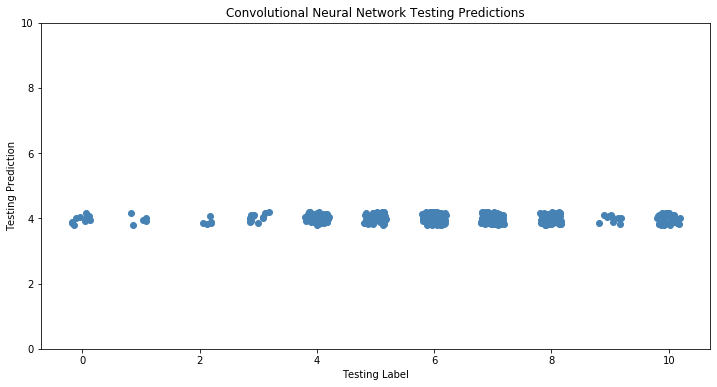

In [65]:
first_pred = first_estimator.predict(X_test)

x_jitter = np.random.uniform(-0.2, 0.2, len(y_test_labels))
y_jitter = np.random.uniform(-0.2, 0.2, len(y_test_labels))
plt.figure(figsize=[12,6])
plt.scatter(y_test_labels + x_jitter, first_pred + y_jitter, color="steelblue")
plt.xlabel("Testing Label")
plt.ylabel("Testing Prediction")
plt.title("Convolutional Neural Network Testing Predictions")
plt.ylim([0,10])
plt.savefig("../figures/cnn_all_fours.png");

In [84]:
def second_nn_model():
    model = Sequential()
    model.add(Dense(8, input_dim=flattened_shape[1], activation="relu"))
    model.add(Dense(y_train.shape[1], activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["mae", "mse"])
    return model

In [101]:
%%time
second_estimator, second_results = run_keras_cv(second_nn_model, X=flattened_X_train)

CPU times: user 104 ms, sys: 150 ms, total: 254 ms
Wall time: 13.1 s


In [102]:
second_results.mean(), second_results.std()

(2.9173104832484174, 1.9265216813213943)

In [105]:
get_errors(second_estimator, X=flattened_X_train)

(2.1446540880503147, 2.715550374505689)

In [22]:
def third_nn_model():
    model = Sequential()
    model.add(Dense(8, input_dim=flattened_shape[1], activation="relu"))
    model.add(Dense(y_train.shape[1], activation="sigmoid"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["mae", "mse"])
    return model

In [107]:
%%time
third_estimator, third_results = run_keras_cv(third_nn_model, X=flattened_X_train)

CPU times: user 44.4 ms, sys: 32.3 ms, total: 76.6 ms
Wall time: 14.7 s


In [108]:
third_results.mean(), third_results.std()

(4.389979928979466, 1.662370389877224)

In [110]:
get_errors(third_estimator, X=flattened_X_train)

(1.6666666666666667, 2.2695689890872264)

In [23]:
def fourth_nn_model():
    model = Sequential()
    model.add(Dense(8, input_dim=flattened_shape[1], activation="relu"))
    model.add(Dropout(0.25, seed=42))
    model.add(Dense(y_train.shape[1], activation="sigmoid"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["mae", "mse"])
    return model

In [114]:
%%time
fourth_estimator, fourth_results = run_keras_cv(fourth_nn_model, X=flattened_X_train)

CPU times: user 78.6 ms, sys: 88.3 ms, total: 167 ms
Wall time: 12.4 s


In [115]:
fourth_results.mean(), fourth_results.std()

(4.214732129072101, 1.5027730742846714)

In [117]:
get_errors(fourth_estimator, X=flattened_X_train)

(6.122641509433962, 6.473215253895891)

In [149]:
fourth_estimator.predict(flattened_X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0,

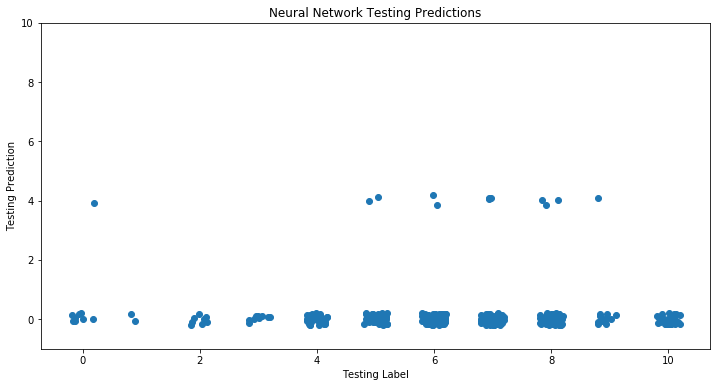

In [170]:
fourth_pred = fourth_estimator.predict(flattened_X_test)

x_jitter = np.random.uniform(-0.2, 0.2, len(y_test_labels))
y_jitter = np.random.uniform(-0.2, 0.2, len(y_test_labels))
plt.figure(figsize=[12,6])
plt.scatter(y_test_labels + x_jitter, fourth_pred + y_jitter)
plt.xlabel("Testing Label")
plt.ylabel("Testing Prediction")
plt.title("Neural Network Testing Predictions")
plt.ylim([-1,10])
plt.savefig("../figures/nn_most_zeros.png");

In [24]:
def fifth_nn_model():
    model = Sequential()
    model.add(Conv2D(64, (2,2), input_shape=input_shape, activation="relu"))
    model.add(Dropout(0.25, seed=42))
    model.add(Flatten())
    model.add(Dense(y_train.shape[1], activation="sigmoid"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["mae", "mse"])
    return model

In [142]:
%%time
fifth_estimator, fifth_results = run_keras_cv(fifth_nn_model)

CPU times: user 132 ms, sys: 148 ms, total: 280 ms
Wall time: 11min 17s


In [143]:
fifth_results.mean(), fifth_results.std()

(3.326252894858731, 2.0300634989517286)

In [144]:
get_errors(fifth_estimator)

(2.5754716981132075, 3.0266115308196664)

In [147]:
fifth_estimator.predict(X_test)

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [25]:
def make_nn(*n_nodes, output_activation="sigmoid"):
    model = Sequential()
    model.add(Dense(n_nodes[0], input_dim=flattened_shape[1], activation="relu"))
    
    for i in n_nodes[1:]:
        model.add(Dense(i, activation="relu"))
    
    model.add(Dense(y_train.shape[1], activation=output_activation))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["mae", "mse"])
    return model

In [181]:
%%time
sixth_estimator, sixth_results = run_keras_cv(
    lambda: make_nn(128, 64, 32, 16, output_activation="sigmoid"), X=flattened_X_train)

CPU times: user 114 ms, sys: 618 ms, total: 732 ms
Wall time: 2min 44s


In [183]:
get_errors(sixth_estimator, X=flattened_X_train)

(6.223270440251572, 6.553361036941513)

In [184]:
%%time
seventh_estimator, seventh_results = run_keras_cv(
    lambda: make_nn(128, 32, 8, output_activation="softmax"), X=flattened_X_train)

CPU times: user 60.5 ms, sys: 80.9 ms, total: 141 ms
Wall time: 1min 56s


In [185]:
get_errors(seventh_estimator, X=flattened_X_train)

(5.265723270440252, 5.612486080160912)

After the above exploration, we move to a more systematic way of testing multiple networks. The function `fcnn_1h` builds fully-connected neural networks with different numbers of hidden units.

In [132]:
def fcnn_1h(hidden_input_dim, dropout=False):
    model = Sequential()
    if dropout:
        model.add(Dropout(0.25, seed=42))
    model.add(Dense(hidden_input_dim, input_dim=flattened_shape[1], activation="relu"))
    model.add(Dense(y_train.shape[1], activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["mae", "mse"])
    return model

In [68]:
e = KerasClassifier(build_fn=lambda: fcnn_1h(64), epochs=epochs, batch_size=batch_size, verbose=0)
history = e.fit(flattened_X_train, y_train, callbacks=[logger], validation_split=0.2)

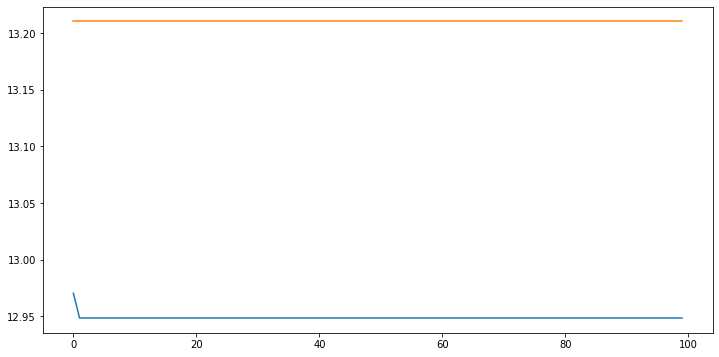

In [74]:
plt.figure(figsize=[12,6])
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

The cells below using `fcnn_1h` to test various model hyperparameters.

In [ ]:
for i in 2 ** np.arange(11):
    e, r = run_keras_cv(lambda: fcnn_1h(i), X=flattened_X_train, epochs=20, batch_size=16)
    print("hdim = {}, MAE = {}".format(i, r.mean()))

In [80]:
for i in 2 ** np.arange(11):
    e, r = run_keras_cv(lambda: fcnn_1h(i), X=flattened_X_train, epochs=20, batch_size=100)
    print("hdim = {}, MAE = {}".format(i, r.mean()))

hdim = 1, MAE = 1.492082754361587
hdim = 2, MAE = 1.7267284236529257
hdim = 4, MAE = 1.492082754361587
hdim = 8, MAE = 1.6038937779836346
hdim = 16, MAE = 2.000744171684422
hdim = 32, MAE = 1.5101219700478616
hdim = 64, MAE = 1.9719283618959391
hdim = 128, MAE = 1.9305944109927435
hdim = 256, MAE = 1.5031063764088313
hdim = 512, MAE = 3.0292511965416082
hdim = 1024, MAE = 1.6038937779836346


In [87]:
for i in 2 ** np.arange(11):
    e, r = run_keras_cv(lambda: fcnn_1h(i, dropout=True), X=flattened_X_train, epochs=20)
    print("hdim = {}, MAE = {}".format(i, r.mean()))

hdim = 1, MAE = 1.492082754361587
hdim = 2, MAE = 1.492082754361587
hdim = 4, MAE = 1.9807102053419794
hdim = 8, MAE = 1.759533734753744
hdim = 16, MAE = 1.492082754361587
hdim = 32, MAE = 1.820061756986259
hdim = 64, MAE = 2.385916319283619
hdim = 128, MAE = 2.072474911224332
hdim = 256, MAE = 1.7267284236529257
hdim = 512, MAE = 1.989720549637178
hdim = 1024, MAE = 2.6282692604600895


Moving onto convolutional networks, the function `cnn_1h` is analagous to `fcnn_1h` for convolutional networks.

In [27]:
def cnn_1h(outputs, windows, dropout=False):
    model = Sequential()
    for output, window in zip(outputs, windows):
        model.add(Conv2D(output, window, activation="relu", input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(dummy_y.shape[1], activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["mae", "mse"])
    return model

The cells below test various network architectures.

In [30]:
%%time
e, r = run_keras_cv(lambda: cnn_1h([64, 32, 32, 32], [(4, 4) for _ in range(4)], dropout=True), 
                    epochs=10, batch_size=100, verbose=1)
# print("hdim = {}, MAE = {}".format(i, r.mean()))

CPU times: user 155 ms, sys: 253 ms, total: 408 ms
Wall time: 54min 53s


In [ ]:
r

In [133]:
%%time
e, r = run_keras_cv(lambda: cnn_1h([64, 32, 32, 16, 16, 16], [(4, 4) for _ in range(6)], dropout=True), 
                    epochs=10, batch_size=100, verbose=1)
# print("hdim = {}, MAE = {}".format(i, r.mean()))

CPU times: user 213 ms, sys: 314 ms, total: 527 ms
Wall time: 59min 7s


In [134]:
r

array([1.75294118, 1.56078431, 1.66141732, 1.40551181, 1.49212598])

In [137]:
%%time
e.fit(X_train, y_train)

Epoch 1/10
1272/1272 [==============================] - 123s 97ms/step - loss: 7.8241 - mae: 0.1524 - mse: 0.1147
Epoch 2/10
1272/1272 [==============================] - 114s 89ms/step - loss: 2.3237 - mae: 0.1602 - mse: 0.0811
Epoch 3/10
1272/1272 [==============================] - 111s 88ms/step - loss: 1.9963 - mae: 0.1494 - mse: 0.0744
Epoch 4/10
1272/1272 [==============================] - 112s 88ms/step - loss: 1.6100 - mae: 0.1309 - mse: 0.0637
Epoch 5/10
1272/1272 [==============================] - 112s 88ms/step - loss: 1.1484 - mae: 0.0968 - mse: 0.0473
Epoch 6/10
1272/1272 [==============================] - 112s 88ms/step - loss: 0.7834 - mae: 0.0687 - mse: 0.0324
Epoch 7/10
1272/1272 [==============================] - 113s 89ms/step - loss: 0.5556 - mae: 0.0472 - mse: 0.0219
Epoch 8/10
1272/1272 [==============================] - 113s 89ms/step - loss: 0.4673 - mae: 0.0390 - mse: 0.0180
Epoch 9/10
1272/1272 [==============================] - 115s 90ms/step - loss: 0.3583 - 

In [143]:
preds = e.predict(X_test)
rmse(preds, y_test_labels), mae(preds, y_test_labels)

(2.6207318241509654, 1.9694117647058824)

In [144]:
e.model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 89, 137, 64)       3136      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 86, 134, 32)       32800     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 83, 131, 32)       16416     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 80, 128, 16)       8208      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 77, 125, 16)       4112      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 74, 122, 16)       4112      
_________________________________________________________________
flatten_3 (Flatten)          (None, 144448)           

425/425 [==============================] - 14s 32ms/step


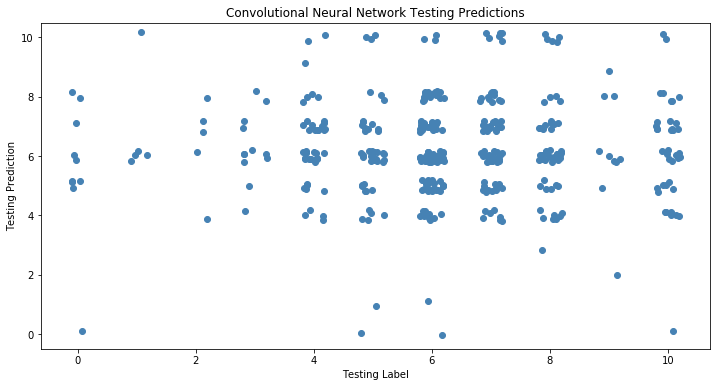

In [142]:
x_jitter = np.random.uniform(-0.2, 0.2, len(y_test_labels))
y_jitter = np.random.uniform(-0.2, 0.2, len(y_test_labels))
plt.figure(figsize=[12,6])
plt.scatter(y_test_labels + x_jitter, preds + y_jitter, color="steelblue")
plt.xlabel("Testing Label")
plt.ylabel("Testing Prediction")
plt.title("Convolutional Neural Network Testing Predictions")
plt.ylim([-.5,10.5])
plt.savefig("../figures/better_cnn.png");

The cells below use `visualize_layer` to visualize the first NN model (all-fours) and the last one above.

In [110]:
first_estimator.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 91, 139, 32)       416       
_________________________________________________________________
activation_1 (Activation)    (None, 91, 139, 32)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 69, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 68, 32)        4128      
_________________________________________________________________
activation_2 (Activation)    (None, 44, 68, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 34, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 33, 64)       

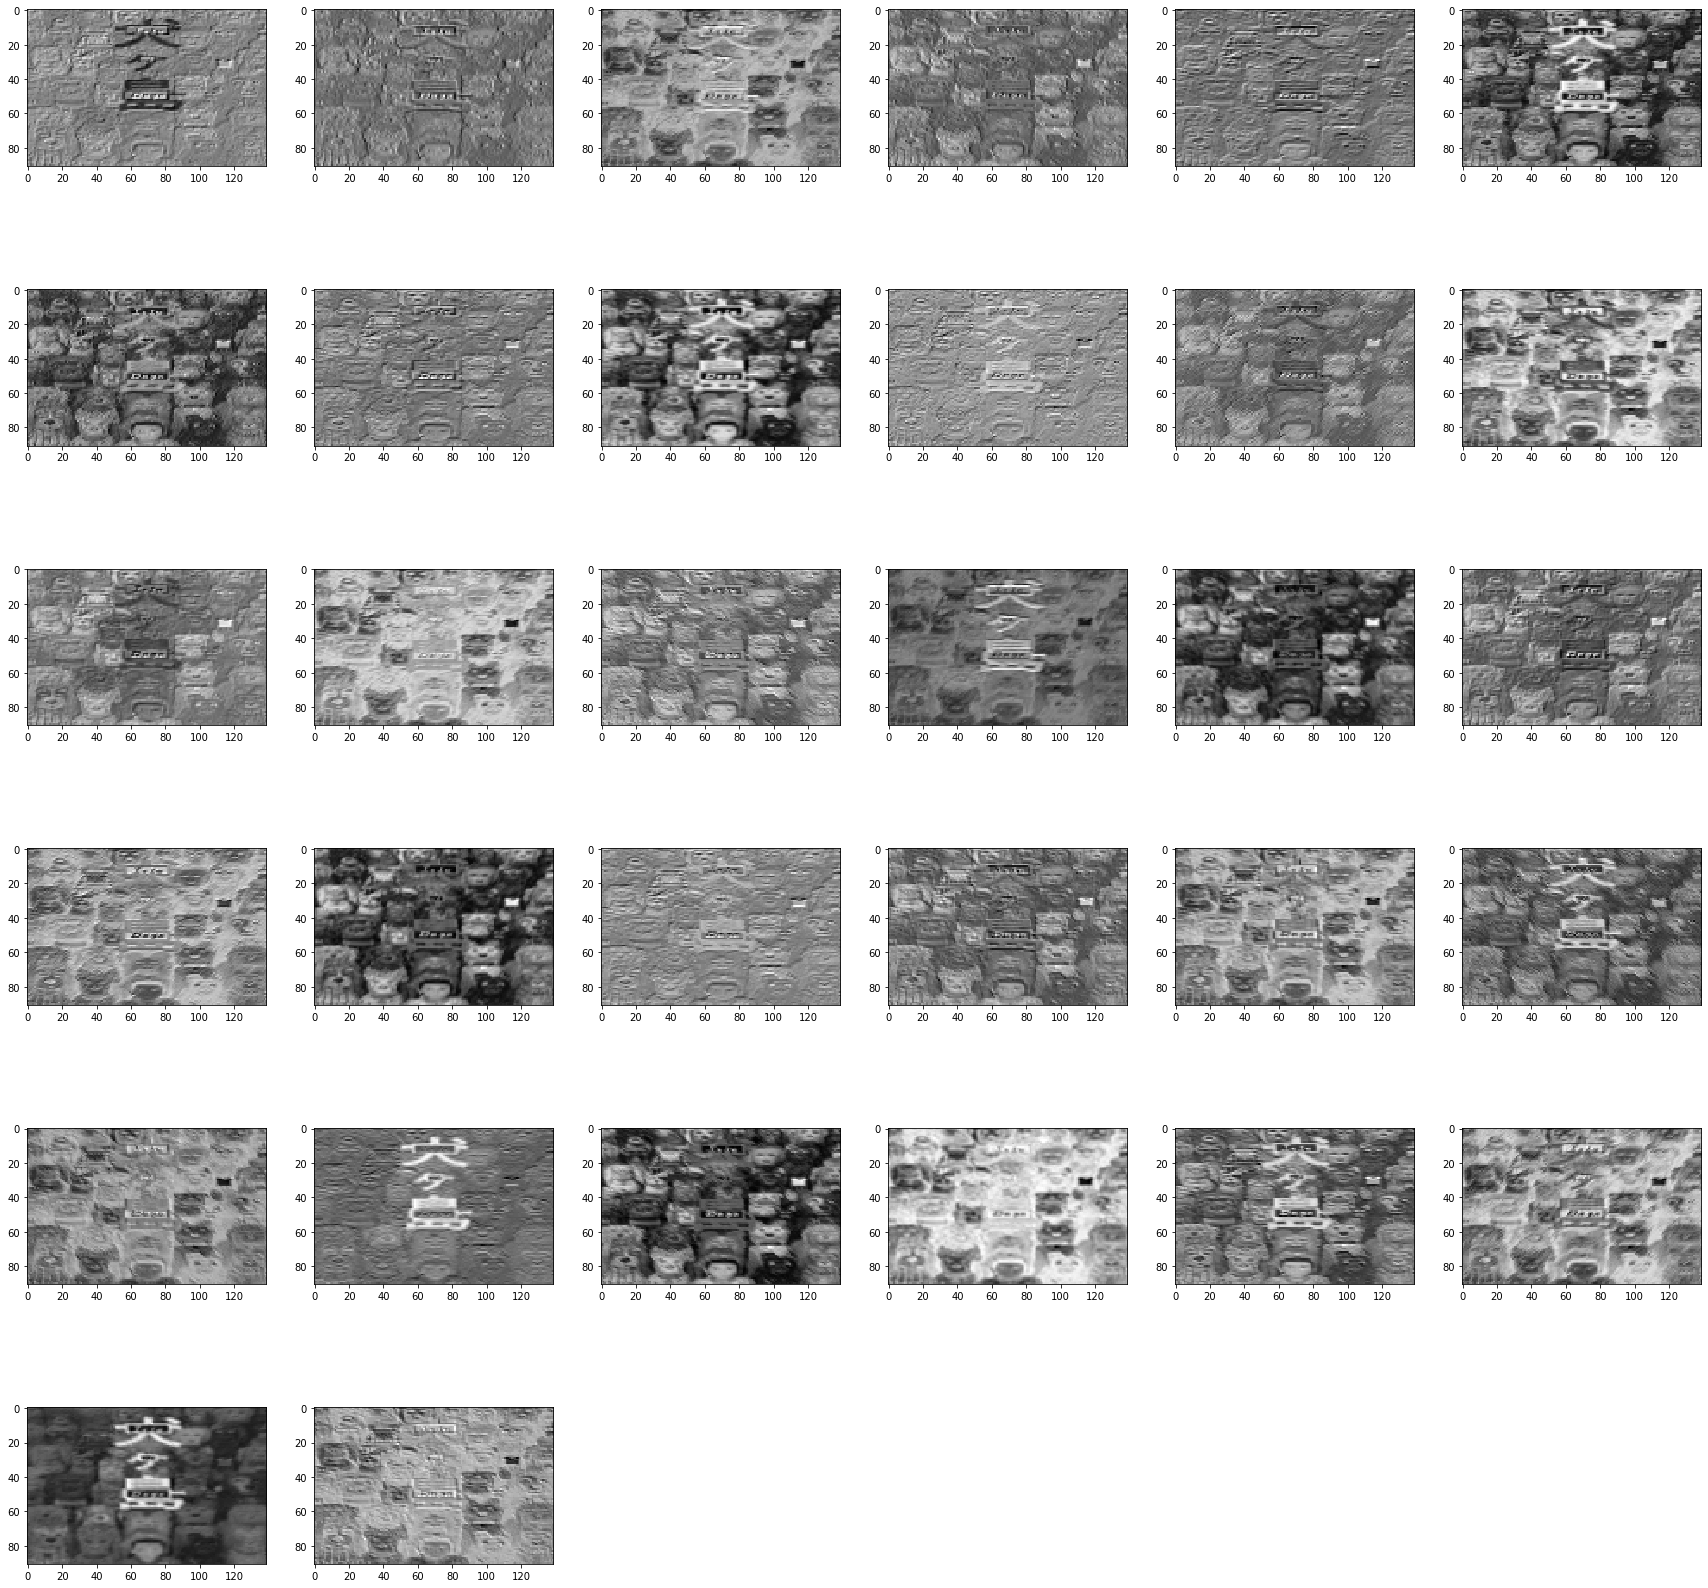

In [148]:
visualize_layer(first_estimator, 0, (6,6), [30,30])
plt.savefig("../figures/cnn_all_fours_first_layer.png", bbox_inches="tight")

In [ ]:
e.summary()

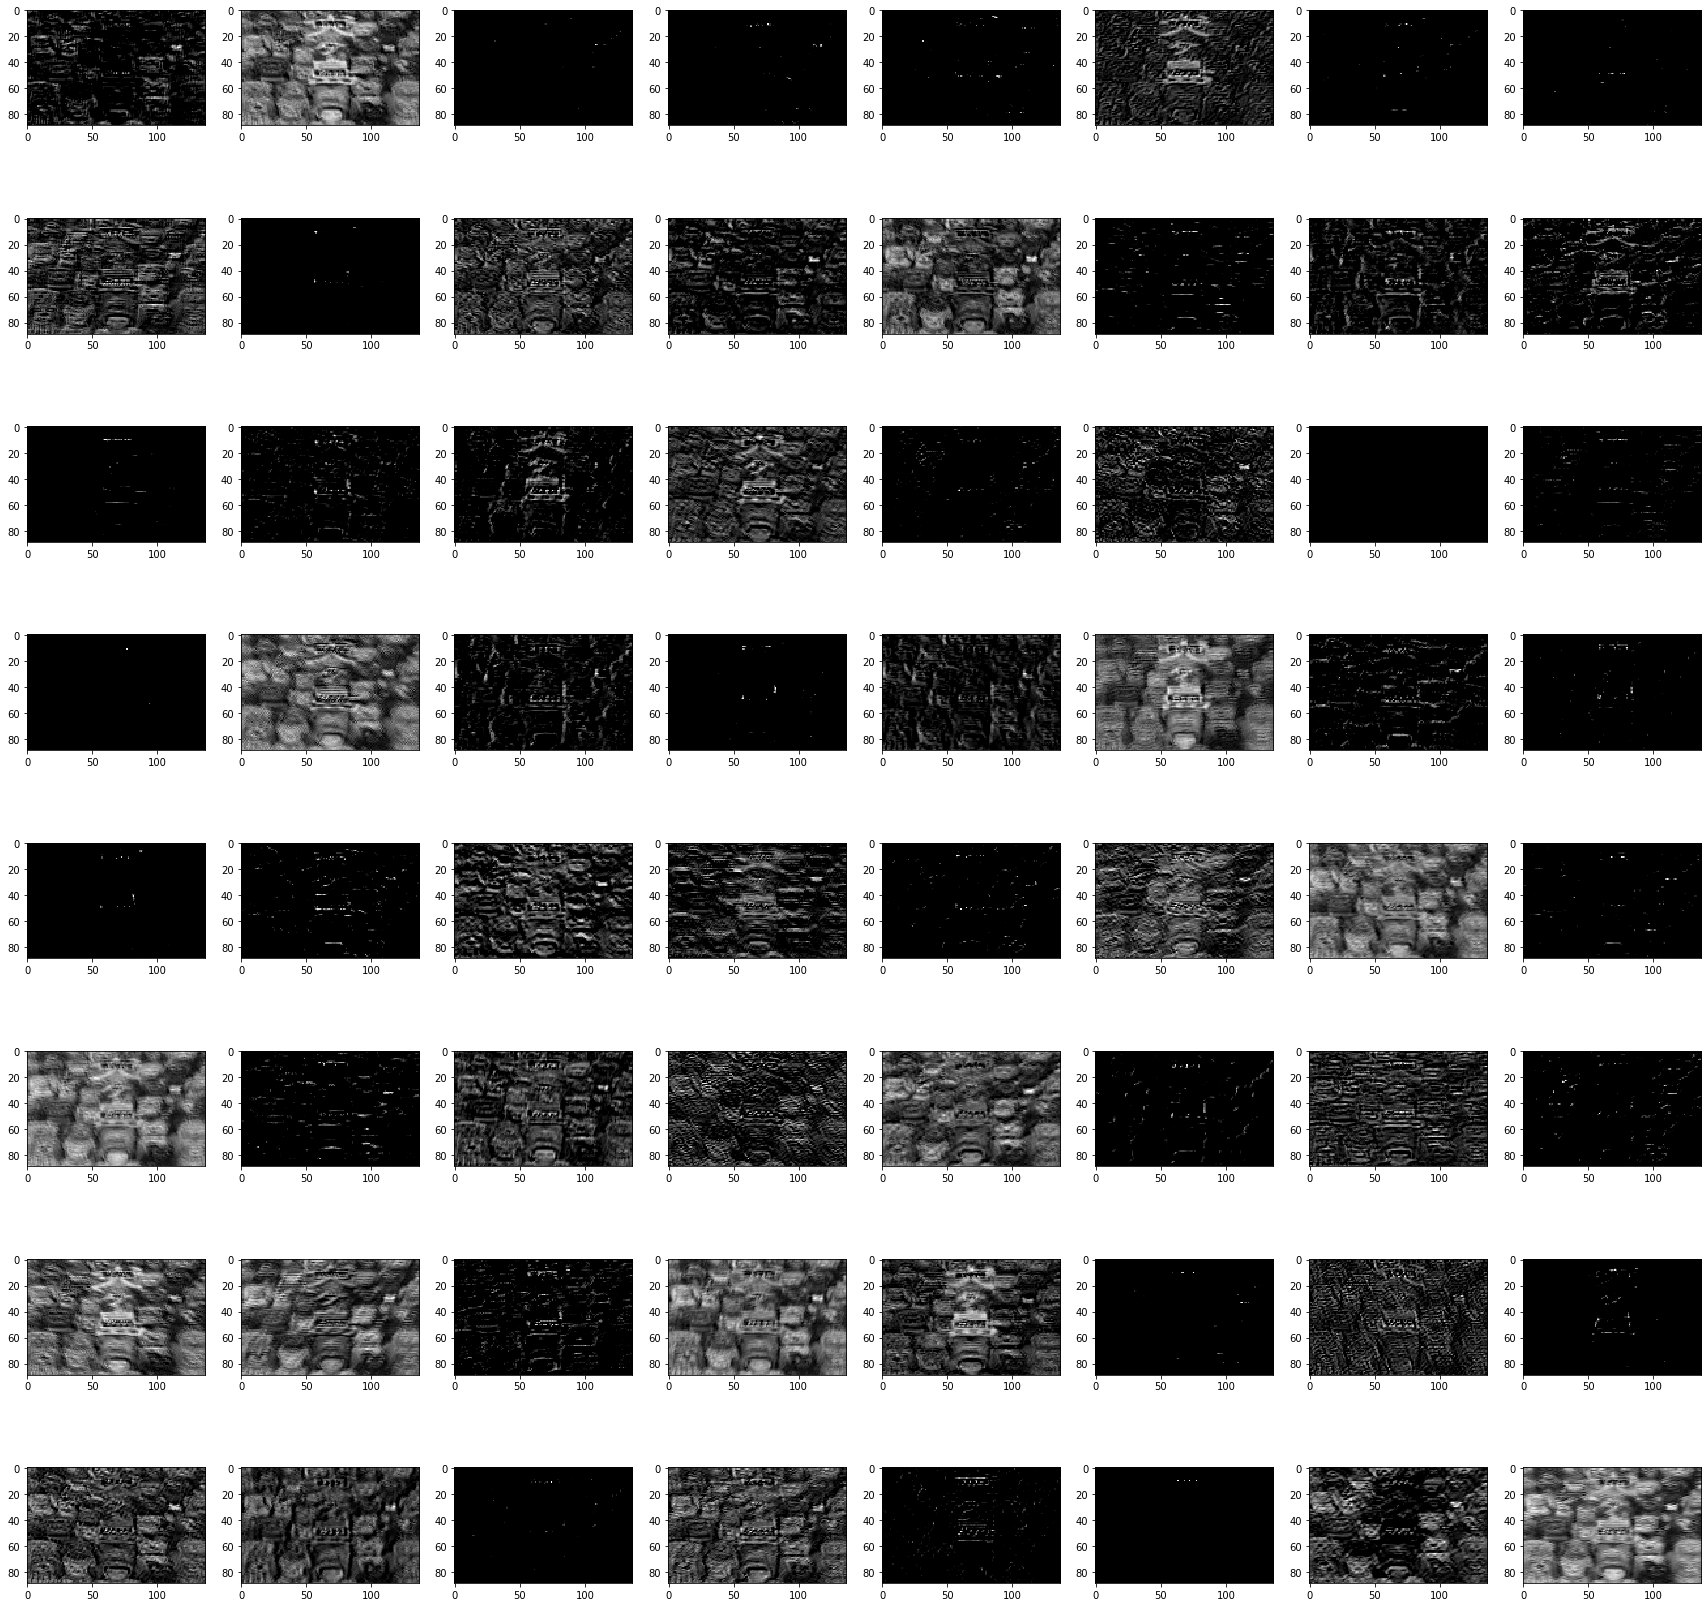

In [159]:
visualize_layer(e, 0, (8,8), [30,30])
plt.savefig("../figures/better_cnn_first_layer.png", bbox_inches="tight")

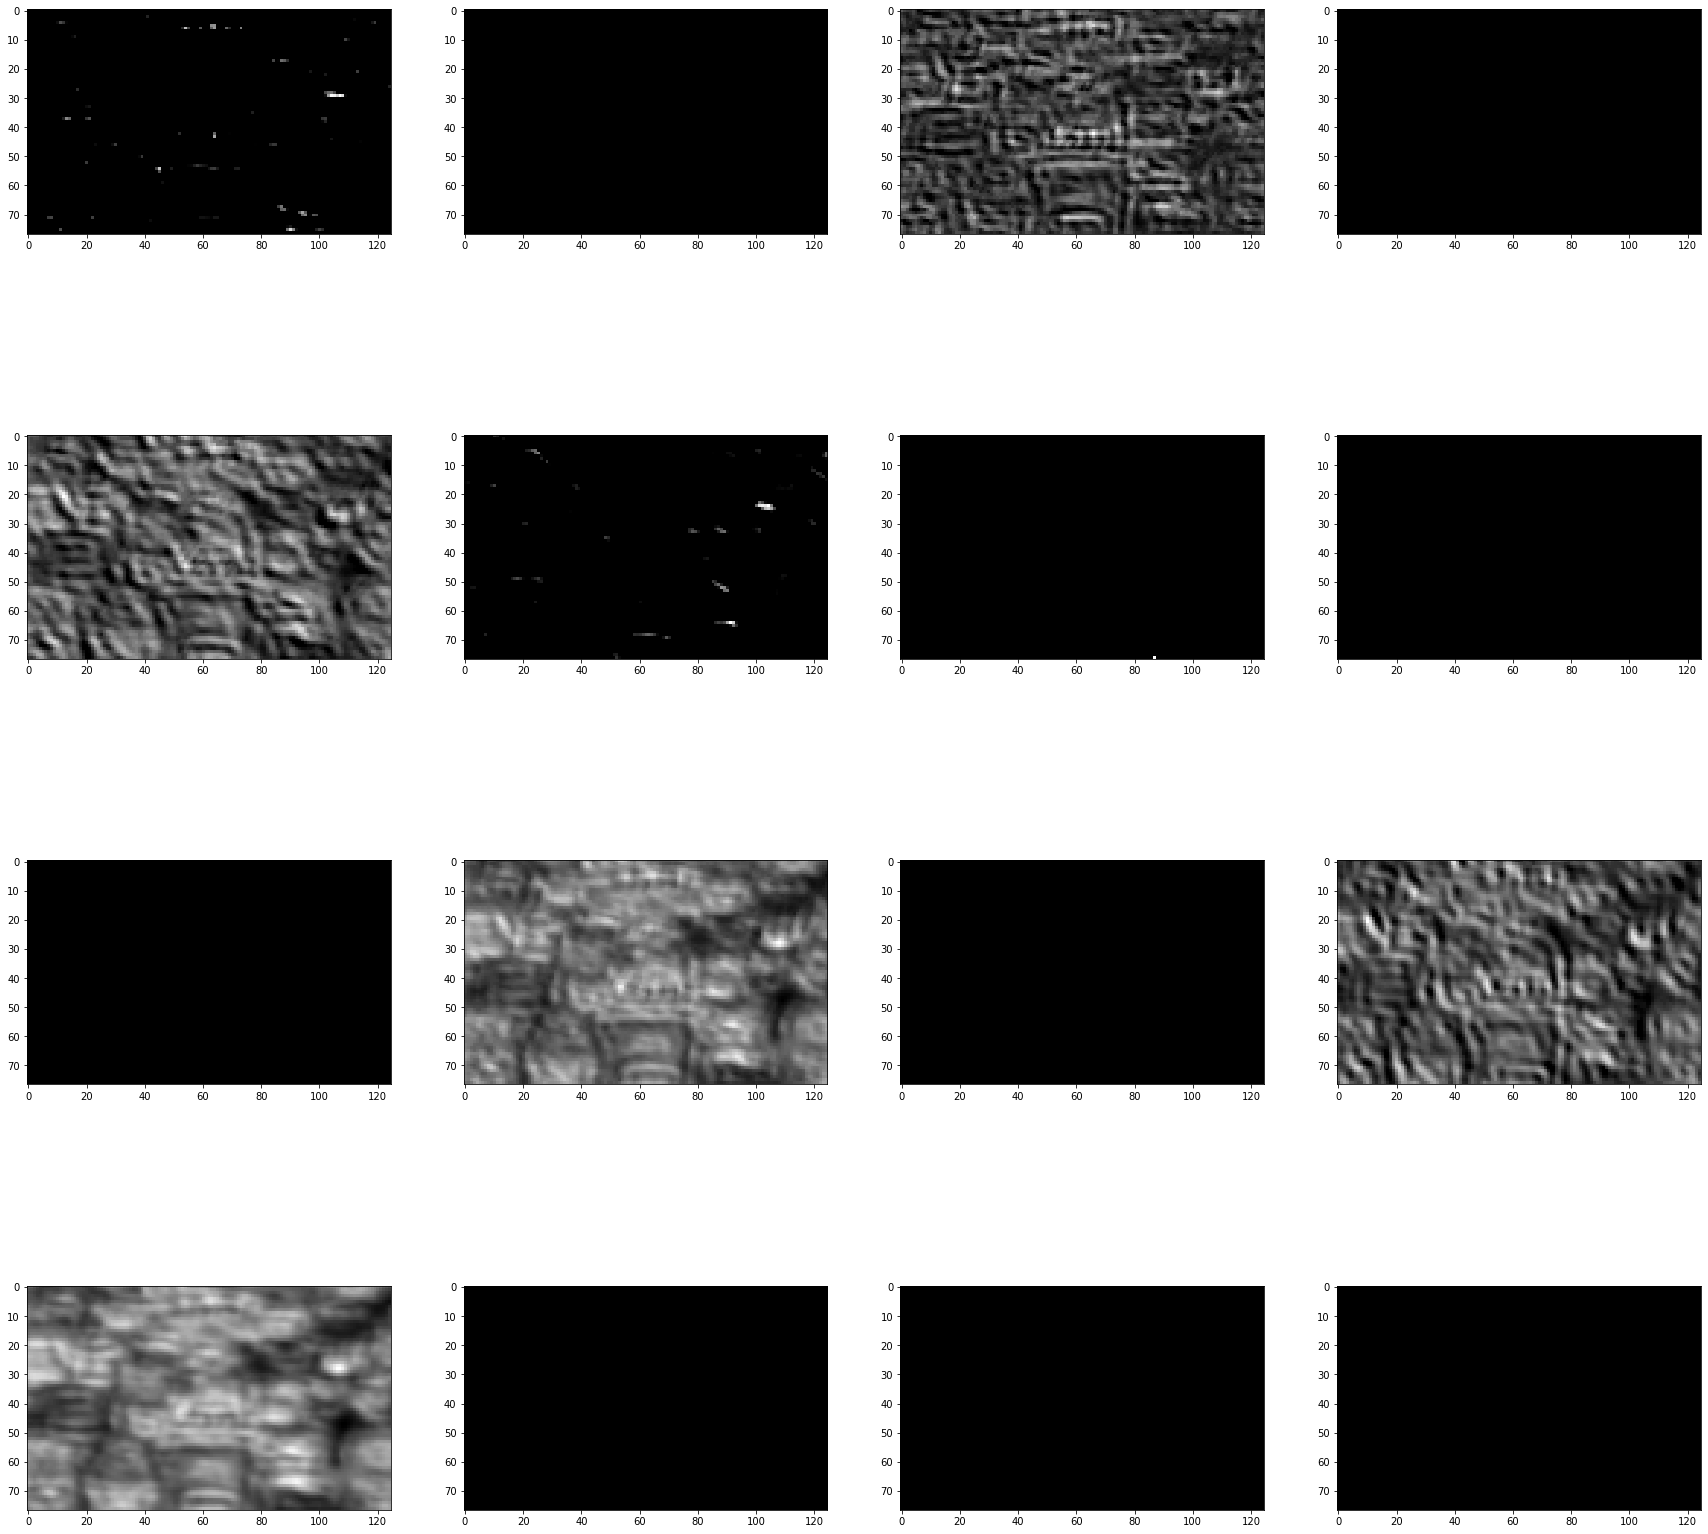

In [160]:
visualize_layer(e, 4, (4,4), [30,30])
plt.savefig("../figures/better_cnn_fifth_layer.png", bbox_inches="tight")